In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='50GB',
                       walltime="12:00:00")


/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38367 instead
  warnings.warn(


In [2]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:39739 Dashboard: http://128.104.200.53:38367/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def map8bit(data):
      return ((data - data.min())/(data.max() - data.min())*255).astype('int8')

def findcom(data):
    if data.ndim<4:
        data = data[np.newaxis,np.newaxis, :,:]
    kx, ky = data.shape[2:]
    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    weights_x, weights_y = np.meshgrid(ky,kx)

    COM = np.zeros((data.shape[0],data.shape[1],2))
    
    for irow in range(data.shape[0]):
        for icol in range(data.shape[1]):
            sample = data[irow, icol, :,:]
            COM[irow,icol,0] = np.average(weights_x,weights = sample)
            COM[irow,icol,1] = np.average(weights_y,weights = sample)

    return COM.squeeze()


def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

def houghcenter(sample, thres, radiimin, radiimax):
    
    bw = 1.0*(sample > thres)
    selem = disk(3)
    bw2 = closing(bw, selem)
    edges = feature.canny(bw2)

    sample = sample.astype('uint8')
    temp = edges.astype('uint8')

    image = sample

    # Detect two radii
    hough_radii = np.arange(radiimin,radiimax,1)
    hough_res = hough_circle(temp, hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    try:
        cx = int(np.average(cx))
        cy = int(np.average(cy))
        radii = int(np.average(radii))
        
    except:
        cx = None
        cy = None

    #print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)
    #if cx == None or cy == None:
    #print('None')
    
    return cx, cy 
def Reconstruction(signal_slice, cx, cy, BF_radius, withADF, thres):
    
    signal_slice.data[signal_slice.data<thres] = 0
    rx,ry,kx,ky = signal_slice.data.shape
    PACBED = np.zeros((kx,ky))
    #COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210621/86000fpsA30um/BlankCOM.npy')##############

    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    kx2,ky2 = np.meshgrid(ky,kx)## swaped

    COM_exp = np.zeros((rx,ry,2))
    COM_exp_ang = np.zeros((rx,ry))
    BF = np.zeros((rx,ry))
    ABF = np.zeros((rx,ry))
    eBF = np.zeros((rx,ry))
    ADF = np.zeros((rx,ry))

    ABF_radius = BF_radius/2
    ADF_radius = BF_radius*1.36

    for ix in range(rx):
        for iy in range(ry):

            frame = signal_slice.data[ix,iy,:,:]

            #cx = COM[ix,iy,0]
            #cy = COM[ix,iy,1]

            distance_from_center = np.sqrt((kx2 - cx)**2 + (ky2-cy)**2)
            ADF_mask = (distance_from_center > (BF_radius)) & (distance_from_center <= (ADF_radius))
            ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
            BF_mask = distance_from_center <= BF_radius
            lBF_mask = distance_from_center <= ABF_radius

            res = ndimage.measurements.center_of_mass(signal_slice.data[ix,iy,:,:]*BF_mask)
            COM_exp[ix,iy,0] = res[0]-cx
            COM_exp[ix,iy,1] = res[1]-cy        
            BF[ix,iy] = (frame*BF_mask).sum()
            ABF[ix,iy] = (frame*ABF_mask).sum()
            ADF[ix,iy] = (frame*ADF_mask).sum() if withADF else None
            eBF[ix,iy] = ABF[ix,iy]-(frame*lBF_mask).sum()
            PACBED = PACBED + frame
    
    return COM_exp, BF, ABF, eBF, PACBED, ADF

In [4]:
import time
import SeqIO
from SeqIO.version import __version__
from SeqIO.CeleritasSeqReader import SeqReader
from SeqIO.utils.file_utils import read_ref

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
#import cv2
from scipy import optimize
from skimage import feature
from pylab import *
import struct
#import mrcfile
import math
import sys

#from skimage import data, color
from scipy import ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load from merged seq file

In [ ]:
filename = '/srv/home/voyles/home-chenyu/DEbackup/2019/081619/S0/S0.seq'
dark = '/srv/home/voyles/home-chenyu/DEbackup/2019/081619/S0/S0.seq.dark.mrc'
gain = '/srv/home/voyles/home-chenyu/DEbackup/2019/081619/S0/S0.seq.gain.mrc'
metadata = '/srv/home/voyles/home-chenyu/DEbackup/2019/081619/S0/S0.seq.metadata'
xml_file = '/srv/home/voyles/home-chenyu/DEbackup/2019/081619/S0/S0.seq.Config.Metadata.xml'

In [ ]:
dataload = SeqIO.load(seq = filename,
                      gain = gain,
                      dark=dark,
                      metadata=metadata,
                      xml_file=xml_file,
                      lazy=True,
                      chunk_shape=100,
                      nav_shape=(150,150),
                     )

In [ ]:
dataload.data.shape

In [6]:
blank = SeqIO.load_folder('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/Rawdata/20211213/Vacuum/',lazy=True, chunk_shape=(64,64), nav_shape=(256,256))
blank.compute()

In [7]:
com = findcom(blank.data)


<IPython.core.display.Javascript object>


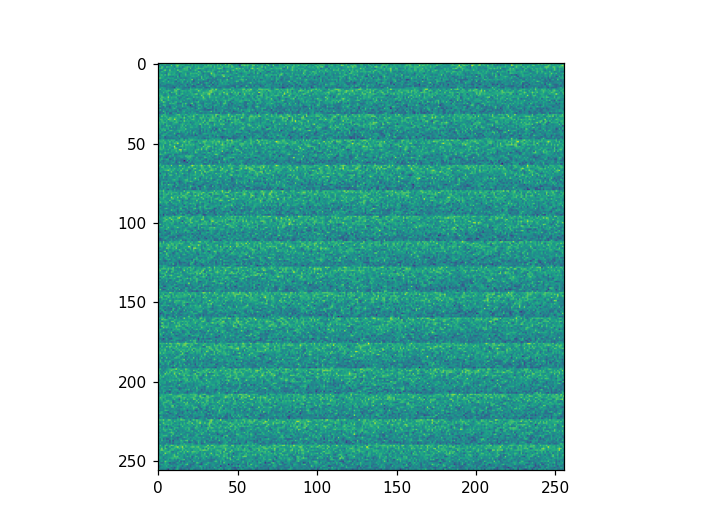

In [8]:
%matplotlib notebook
plt.imshow(com[:,:,0])

In [60]:
np.unique(com[:,:,1])

array([62.91420057, 65.1791426 , 65.27042285, ..., 68.3364412 ,
       68.36417004, 68.37831852])

In [9]:
s = SeqIO.load_folder('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/Rawdata/20211213/',lazy=True, chunk_shape=(1, 64,64), nav_shape=(40, 256,256))
s.data

,Array,Chunk
Bytes,320.00 GiB,512.00 MiB
Shape,"(40, 256, 256, 128, 256)","(1, 64, 64, 128, 256)"
Count,1922 Tasks,640 Chunks
Type,float32,numpy.ndarray


In [10]:
ss = s.inav[:,:,1]
ss.data
ss.compute()

ERROR! Session/line number was not unique in database. History logging moved to new session 339


<IPython.core.display.Javascript object>


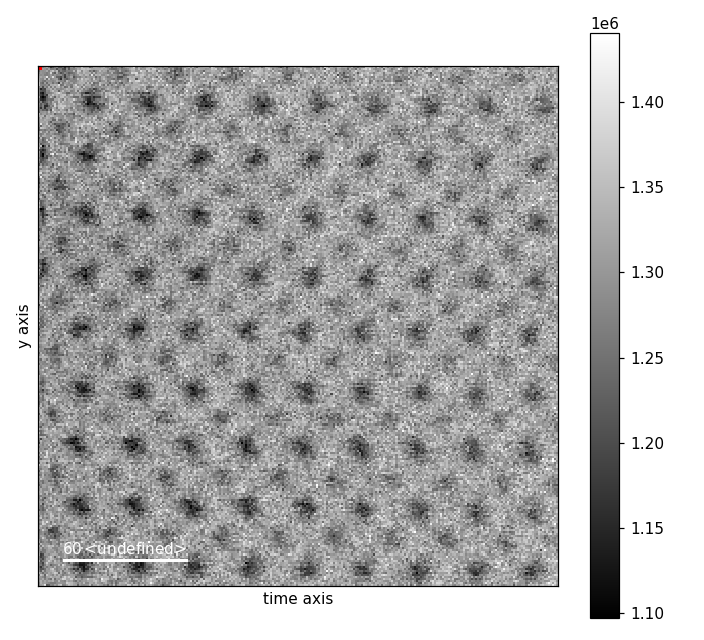

<IPython.core.display.Javascript object>


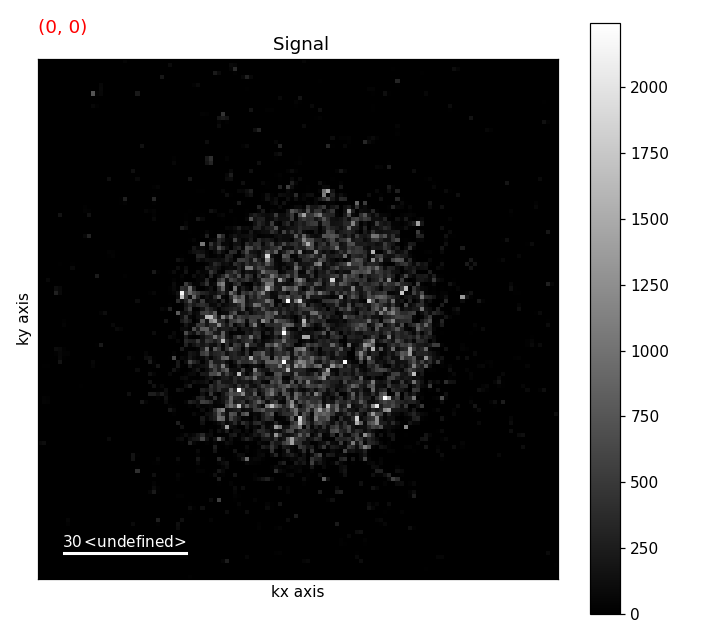

In [24]:
ss.set_signal_type('electron_diffraction')
ssc = ss.isig[64:-64,:]
ssc.plot()

In [25]:
shift_x = com[:,:,0]-128
shift_y = com[:,:,1]-65
ssc.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                  parallel=False,inplace=False,show_progressbar=True)

  0%|          | 0/65536 [00:00<?, ?it/s]

MemoryError: Unable to allocate 2.00 GiB for an array with shape (65536, 128, 128) and data type uint16

<IPython.core.display.Javascript object>


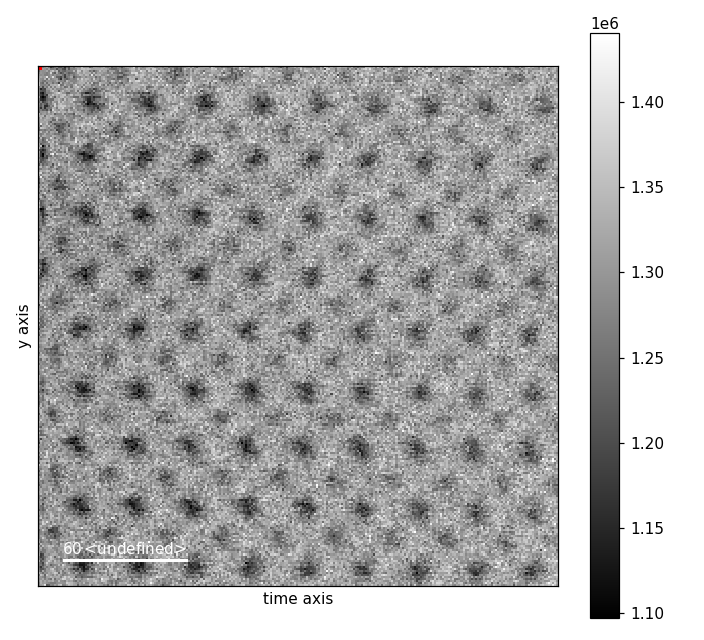

<IPython.core.display.Javascript object>


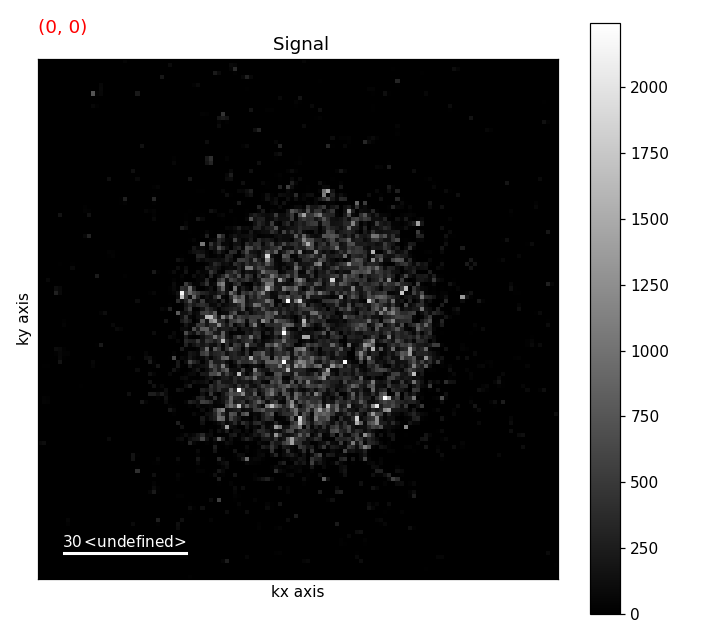

In [26]:
ssc.plot()

In [ ]:
ss.save('/srv/home/jwei74/4DSTEMdata/20211213' + 'rawfc1.hdf5')

In [42]:
COM_exp, BF, ABF, eBF, PACBED, ADF = Reconstruction(ss, 129, 65, 15, withADF = True, thres = 7)

In [52]:
comc = COM_exp-com
#COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(comc[:,:,0]**2 + comc[:,:,1]**2)

<IPython.core.display.Javascript object>


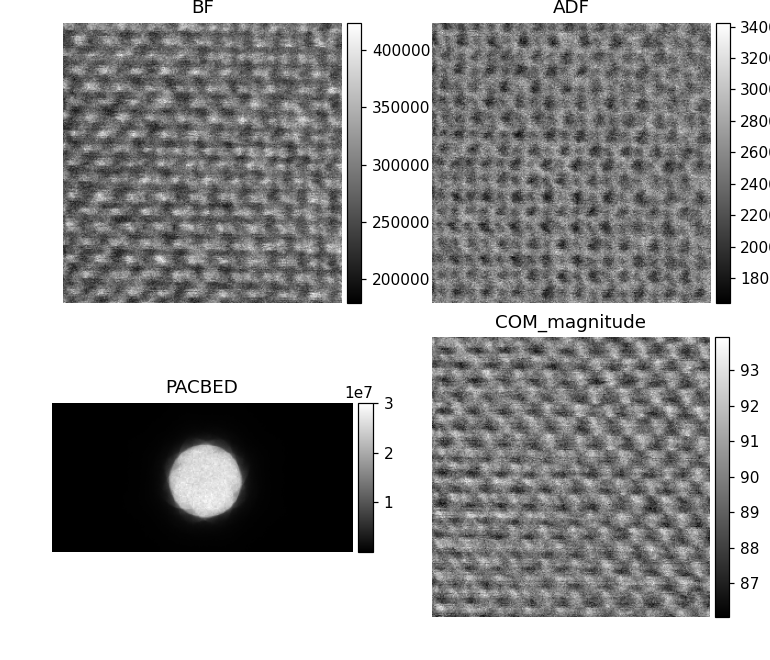

(-0.5, 252.5, 255.5, -0.5)

In [53]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig0, ax0 = plt.subplots(nrows=2, ncols=2, figsize = (7,6))
fig0.tight_layout(h_pad = .1, w_pad = 0)
a = ax0[0,0].imshow(BF[:, 1:-1,], cmap = 'gray')
divider = make_axes_locatable(ax0[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax = cax)
ax0[0,0].set_title('BF')
ax0[0,0].axis('off')

b = ax0[0,1].imshow(ADF[:, 1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(b,cax = cax)
ax0[0,1].set_title('ADF')  
ax0[0,1].axis('off')

c = ax0[1,0].imshow(PACBED[1:-1,1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(c,cax = cax)
ax0[1,0].set_title('PACBED')      
ax0[1,0].axis('off')  

d = ax0[1,1].imshow(COM_exp_mag[:, 2:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(d,cax = cax)
ax0[1,1].set_title('COM_magnitude')      
ax0[1,1].axis('off') 

### Load from folder, top and bottom

Load multi-dimentional data: for dask array in SeqIO and numpy array, the shaping is [fc, nav, nav, pc]; for hyperspy, it's different, [pc, nav, nav, fc]

In [9]:
s = SeqIO.load_folder('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210703/86000fpsSpot9/',lazy=True, chunk_shape=(64,64), nav_shape=(512,512))
s.compute()
ss = s/241
ss.save('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210703/86000fpsSpot9/standardintegration_86000fps.hdf5')

In [4]:
folder ='/srv/home/jwei74/4DSTEMdata/20211206STONRR/movie405/'
signal = SeqIO.load_folder(folder,lazy=True, chunk_shape=(1,256,256), nav_shape=(40,256,256))

In [60]:
ss = signal.inav[:,:,0]
ss.set_signal_type('electron_diffraction')
ss.data
ss.compute()


[########################################] | 100% Completed | 22.6s


In [27]:
ss.save(folder + 'rawfc1.hdf5')

<IPython.core.display.Javascript object>


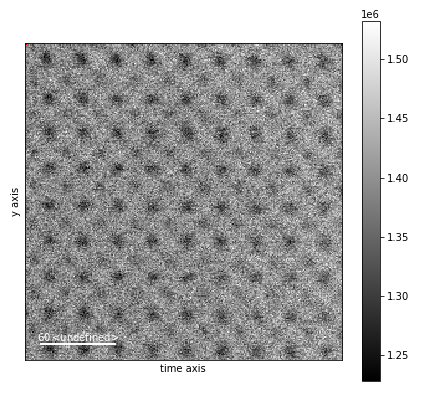

<IPython.core.display.Javascript object>


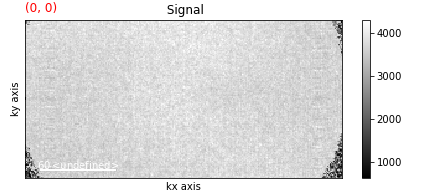

In [101]:
%matplotlib notebook
ss.plot()


### Reconstruction

In [ ]:
roi = hs.roi.CircleROI(cx=98+32,cy=32, r_inner=0, r=31)
rr = signal_slice.plot_integrated_intensity(roi)

get com from blank file

In [33]:
blank = SeqIO.load_folder('/srv/home/jwei74/4DSTEMdata/Blank/EF250_256X256_20M/',lazy=True, chunk_shape=(64,64), nav_shape=(256,256))

This method doesn't work. I think it's due to low SNR

com = blank.center_of_mass(threshold=5,mask=(128,64,40))
com.save('/srv/home/jwei74/4DSTEMdata/Blank/EF250_256X256_20M/com.hdf5')

Neither does my com = findcom(blank.data[:,:,:,64:-64])

In [37]:
blank.compute()
blank.set_signal_type('electron_diffraction')



[########################################] | 100% Completed |  6.4s


/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [116]:
center = np.zeros((256,256,2))

for irow in range(256):
    for icol in range(256):
        img = blank.data[irow, icol, :,:]
        center[irow,icol] = np.squeeze(houghcenter(img, 200, 29,31))
    if irow % 10 == 0:
        print('Finish row', irow) 

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finish row 0
Finish row 10
Finish row 20
Finish row 30
Finish row 40
Finish row 50
Finish row 60
Finish row 70
Finish row 80
Finish row 90
Finish row 100
Finish row 110
Finish row 120
Finish row 130
Finish row 140
Finish row 150
Finish row 160
Finish row 170
Finish row 180
Finish row 190
Finish row 200
Finish row 210
Finish row 220
Finish row 230
Finish row 240
Finish row 250


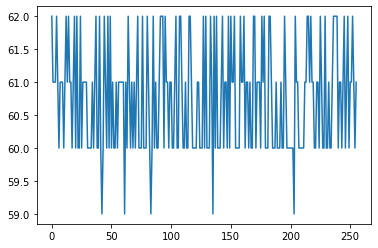

In [126]:
%matplotlib inline
plt.plot(center[12,:,1])

In [119]:
center.shape

(256, 256, 2)

In [ ]:
ss.set_signal_type('electron_diffraction')

shift_x = comc[:,:,0]-129
shift_y = comc[:,:,1]-65
ss.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                  parallel=False,inplace=False,show_progressbar=True)

  0%|          | 0/65536 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-e834accb89a2>", line 5, in <module>
    ss.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/pyxem/signals/diffraction2d.py", line 206, in shift_diffraction
    s_shift = self.map(
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/hyperspy/signal.py", line 4593, in map
    res = self._map_iterate(function, iterating_kwargs=ndkwargs,
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/hyperspy/signal.py", line 4759, in _map_iterate
    for ind, res in zip(range(res_data.size), map(func, zip(*iterators))):
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/hyperspy/misc/utils.py", line 1169, in func
    return function(dat, **these_

In [62]:
# center of the blank: 128 61
# center of the movie 405: 129 62
shift_x = comc.data[0,:,:]-129
shift_y = comc.data[1,:,:]-65
signal_reg = ss.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                  parallel=True,inplace=False,show_progressbar=True)

TypeError: memoryview: invalid slice key

In [129]:
signal_reg.save('/srv/home/jwei74/4DSTEMdata/20211206STONRR/movie405/registeredfc1.hdf5')

Overwrite '/srv/home/jwei74/4DSTEMdata/20211206STONRR/movie405/registeredfc1.hdf5' (y/n)?
y


<IPython.core.display.Javascript object>


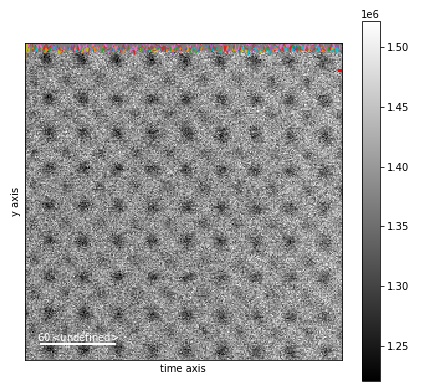

<IPython.core.display.Javascript object>


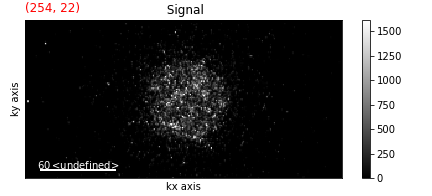

In [71]:
%matplotlib notebook
signal_reg.plot()

In [72]:
COM_exp, BF, ABF, eBF, PACBED, ADF = Reconstruction(signal_reg, 129, 62, 25, withADF = True, thres = 7)

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [73]:
#COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

<IPython.core.display.Javascript object>


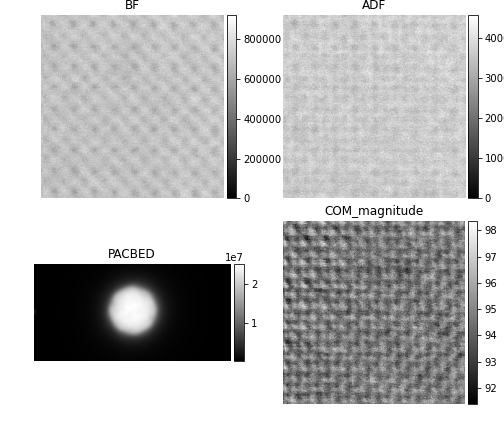

(-0.5, 252.5, 255.5, -0.5)

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig0, ax0 = plt.subplots(nrows=2, ncols=2, figsize = (7,6))
fig0.tight_layout(h_pad = .1, w_pad = 0)
a = ax0[0,0].imshow(BF[:, 1:-1,], cmap = 'gray')
divider = make_axes_locatable(ax0[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax = cax)
ax0[0,0].set_title('BF')
ax0[0,0].axis('off')

b = ax0[0,1].imshow(ADF[:, 1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(b,cax = cax)
ax0[0,1].set_title('ADF')  
ax0[0,1].axis('off')

c = ax0[1,0].imshow(PACBED[1:-1,1:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(c,cax = cax)
ax0[1,0].set_title('PACBED')      
ax0[1,0].axis('off')  

d = ax0[1,1].imshow(COM_exp_mag[:, 2:-1], cmap = 'gray')
divider = make_axes_locatable(ax0[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(d,cax = cax)
ax0[1,1].set_title('COM_magnitude')      
ax0[1,1].axis('off') 

<IPython.core.display.Javascript object>


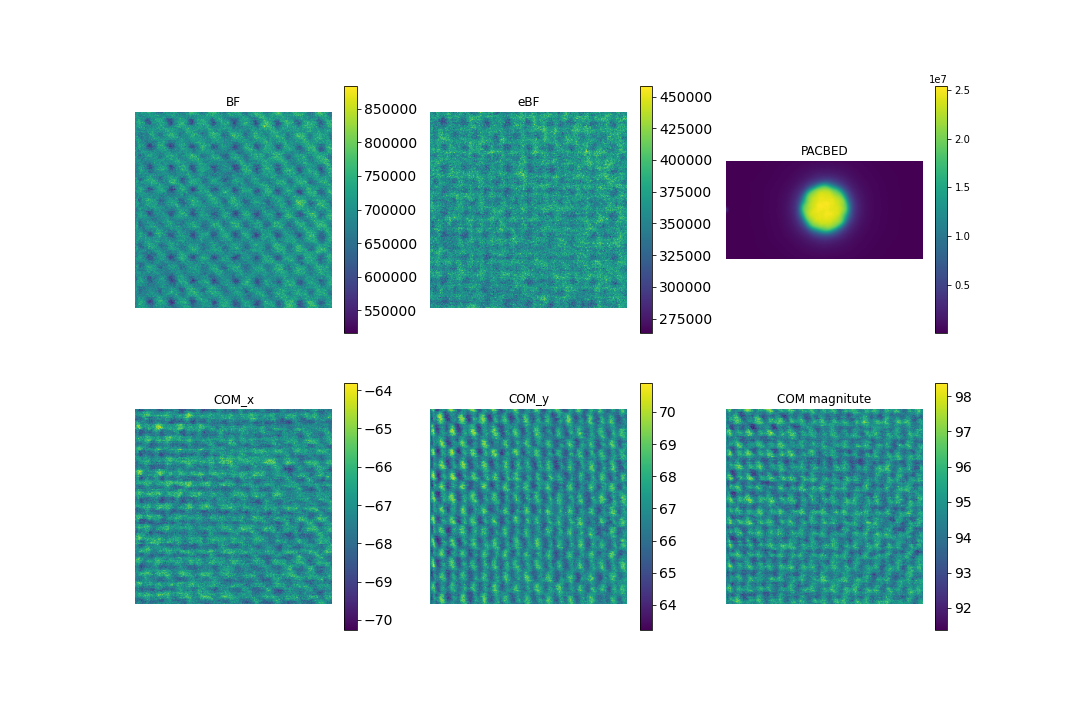

"\nsavepath = '/srv/home/jwei74/rawdata86000fps/1024x1024/'\n#np.save(savepath+'ADF.npy',ADF)\nnp.save(savepath+'COM.npy',COM_exp)\nnp.save(savepath+'BF.npy',BF)\nnp.save(savepath+'ABF.npy',ABF)\nnp.save(savepath+'LBF.npy',lBF)\nnp.save(savepath+'PACBED.npy',PACBED)"

In [75]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(2,3,1)
plt.imshow(BF[1:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('BF')

fig.add_subplot(2,3,2)
plt.imshow(ADF[1:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('eBF')

fig.add_subplot(2,3,3)
plt.imshow(PACBED[1:-1,1:-1])
cbar = plt.colorbar()
plt.axis('off')
plt.title('PACBED')

fig.add_subplot(2,3,4)
plt.imshow(COM_exp[1:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_x')

fig.add_subplot(2,3,5)
plt.imshow(COM_exp[1:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_y')

fig.add_subplot(2,3,6)
plt.imshow(COM_exp_mag[2:-1,:])
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title('COM magnitute')
'''
savepath = '/srv/home/jwei74/rawdata86000fps/1024x1024/'
#np.save(savepath+'ADF.npy',ADF)
np.save(savepath+'COM.npy',COM_exp)
np.save(savepath+'BF.npy',BF)
np.save(savepath+'ABF.npy',ABF)
np.save(savepath+'LBF.npy',lBF)
np.save(savepath+'PACBED.npy',PACBED)'''

### For 5D dataset

In [ ]:
COMseries = np.ones((40,256,256,2))
BFseries = np.ones((40,256,256))
eBFseries = np.ones((40,256,256))
#PACBEDseries = np.ones((40,128,128))
PACBEDseries = np.ones((40,64,64))
ADFseries = np.ones((40,256,256))

thres = 7
cx = 32
cy = 32
BFradius = 20
croph = (93,157) # axis1
cropv = (0,64) # axis0

with open(folder + 'reconstruction_par.txt', 'w') as f:
    f.write('threshold = '+ str(thres))
    f.write('\ncx = '+str(cx))
    f.write('\ncy = '+ str(cy))
    f.write('\nBFradius = '+ str(BFradius))
    f.write('\ncroph = '+ str(croph))
    f.write('\ncropv = '+ str(cropv))
    
for fc in range(signal.data.shape[0]):
    signal_slice = signal.inav[:,:,fc]

    signal_slice.set_signal_type('electron_diffraction')
    signal_slice.crop('kx', start=croph[0], end=croph[1])
    signal_slice.crop('ky', start=cropv[0], end=cropv[1])
    print('Working on: Slice',fc)
    signal_slice.compute()
    

    COM_exp, BF, ABF, eBF, PACBED, ADF = Reconstruction(signal_slice, cx, cy, BFradius, withADF = True, thres = thres)
    COMseries[fc] = COM_exp
    BFseries[fc] = BF
    eBFseries[fc] = eBF
    PACBEDseries[fc] = PACBED
    ADFseries[fc] = ADF

In [27]:
savepath = '/srv/home/jwei74/4DSTEMdata/20210920STOthin/movie223/'

np.save(savepath+'ADFseries.npy',ADFseries/266)
np.save(savepath+'COMseries.npy',COMseries)
np.save(savepath+'BFseries.npy',BFseries/266)
np.save(savepath+'eBFseries.npy',eBFseries/266)
np.save(savepath+'PACBEDseries.npy',PACBEDseries/266)

In [28]:
BFseries = np.load(savepath+'BFseries.npy')
from PIL import Image
img = []
for i in np.arange(40):
    img.append(Image.fromarray(BFseries[i],mode = None)) # F for floating points 32 
img[0].save(savepath+'BFseries.tif', save_all=True, append_images=img[1:])

ADFseries = np.load(savepath+'ADFseries.npy')
from PIL import Image
img = []
for i in np.arange(40):
    img.append(Image.fromarray(ADFseries[i],mode = None)) 
img[0].save(savepath+'ADFseries.tif', save_all=True, append_images=img[1:])


### Counting filter from Carter

In [ ]:

from scipy.ndimage import label
from scipy.ndimage import center_of_mass

def counting_filter3(image, threshold=5):
    image_binary = image > threshold  # more readable
    all_labels, num = label(image_binary)  # get blobs
    obj = center_of_mass(image, all_labels, range(num))
    obj = np.rint(obj).astype(int)
    x = np.zeros(shape=np.shape(image))
    x[obj[:,0],obj[:,1]]=1
    return x

#### Backup

In [10]:
ss

<ElectronDiffraction2D, title: , dimensions: (256, 256|256, 128)>

In [103]:
#pacbed = blank.sum(axis = (0,1)).data
pacbed = blank.inav[10,10].data

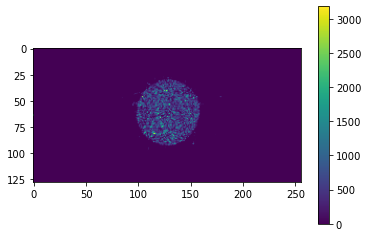

In [114]:
sample = pacbed
plt.imshow(sample)
plt.colorbar()


In [105]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

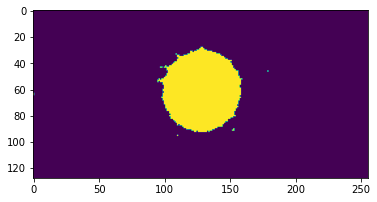

In [115]:
bw = 1.0*(sample > 200)
plt.imshow(bw)
selem = disk(3)
bw2 = closing(bw, selem)
plt.imshow(bw2)
edges = feature.canny(bw2)

[129 128 129] [61 62 60] [31 30 30]
128 61 30


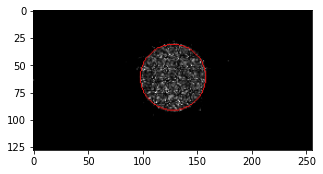

cx axis1: 128 cy axis2: 61 radius: 30


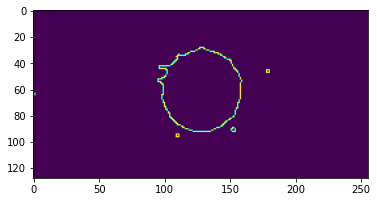

In [113]:
%matplotlib inline
bw = 1.0*(sample > 20)
selem = disk(3)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

#sample = sample*bw*1000000
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
hough_radii = np.arange(10,50,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)

In [ ]:
histogram, bin_edges = np.histogram(d[0].flatten(),bins = 30000)
plt.plot(bin_edges[0:-1], histogram) 

In [ ]:
dd = signal_slice.data

COM = findcom(dd)
avgCOMX = np.sum(COM[:,:,0],axis = (0,1))/ COM.shape[0] /  COM.shape[1]
avgCOMY = np.sum(COM[:,:,1],axis = (0,1))/ COM.shape[0] /  COM.shape[1]
print(avgCOMX,avgCOMY)
print(int(avgCOMX),int(avgCOMY))

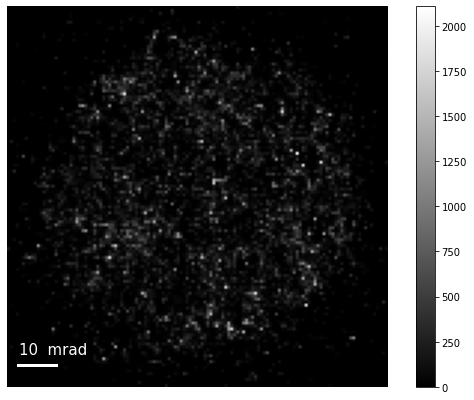

In [34]:
#plot cbed
tenmrad = 10/(23.4/30)
#tenmrad = 10/0.21474808
fig = plt.figure(figsize=(10,7))
#imgh = enhance_contrast(map8bit(signal.data[100,100,:,:]))
#plt.imshow(imgh)
plt.imshow(signal_slice.data[100,100,:,:], cmap = 'gray')
plt.plot([3,3+tenmrad],[120,120],linewidth=3, c = 'white')
plt.text(15,115,'10  mrad', c = 'white',fontsize = 15,horizontalalignment='center',verticalalignment='center')
plt.axis('off')
plt.colorbar()
6
#img = np.asarray(imgh,dtype=np.uint16)
#Image.fromarray(img).save(folder + 'PACBED.tif')

fig.savefig('/srv/home/jwei74/4DSTEMdata/20210910STO/movie199/singleCBED.tif',dpi = 400,bbox_inches='tight') # wrong scale